In [11]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import os
import statsmodels 
import seaborn as sns
import scipy.stats as ss
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts 
import sklearn
import arch
import datetime as dt


from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.stats.stattools import jarque_bera
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from tqdm import tqdm
from time import sleep
import warnings
warnings.filterwarnings('ignore', category=Warning)
sns.set()

In [12]:
def read_csv(name:str):
    df = pd.read_csv(f'../data/processed/{name}.csv')
    df.Date = pd.to_datetime(df.Date)
    df.set_index('Date', inplace = True)
    df.asfreq('12H')
    df.dropna(inplace = True)
    return df

In [13]:
df= read_csv('data_processed')
df_test = read_csv('data_test')

In [14]:
df.head()

,BTCUSDT,ETHUSDT,ADAUSDT,BNBUSDT,Ret_BTCUSDT,Ret_cum_BTCUSDT,Norm_BTCUSDT,Ret_ETHUSDT,Ret_cum_ETHUSDT,Norm_ETHUSDT,Ret_ADAUSDT,Ret_cum_ADAUSDT,Norm_ADAUSDT,Ret_BNBUSDT,Ret_cum_BNBUSDT,Norm_BNBUSDT
Date,,,,,,,,,,,,,,,,
2018-06-01 12:00:00,7521.01,579.00,0.22038,14.2888,2.168340,2.168340,102.168340,1.466800,1.466800,101.466800,2.122335,2.122335,102.122335,3.692308,3.692308,103.692308
2018-06-02 00:00:00,7652.28,592.73,0.22428,14.5000,1.745377,3.913718,103.951563,2.371330,3.838130,103.872912,1.769671,3.892006,103.929564,1.478081,5.170388,105.224964
2018-06-02 12:00:00,7640.03,590.85,0.22648,14.6732,-0.160083,3.753635,103.785155,-0.317176,3.520953,103.543452,0.980917,4.872923,104.949027,1.194483,6.364871,106.481858
2018-06-03 00:00:00,7714.85,619.93,0.23284,14.7861,0.979316,4.732950,104.801539,4.921723,8.442676,108.639574,2.808195,7.681118,107.896200,0.769430,7.134301,107.301161
2018-06-03 12:00:00,7714.26,619.66,0.22659,14.6995,-0.007648,4.725303,104.793524,-0.043553,8.399123,108.592258,-2.684247,4.996871,105.000000,-0.585685,6.548616,106.672714


In [15]:
def fit_auto(df, target, exogenous=None, exog=True, **kwargs):
    if exog:
        model = auto_arima(df[[f'Ret_{target}']], X=df[exogenous], 
                       max_order = None, max_p = 9, max_q = 9, max_d = 2, max_P = 6, max_Q = 6, max_D = 4,
                       maxiter = 70, trend = 'ct')
        print(model.summary())
    else:
        model = auto_arima(df[[f'Ret_{target}']], 
                       max_order = None, max_p = 9, max_q = 9, max_d = 2, max_P = 6, max_Q = 6, max_D = 4,
                       maxiter = 70, trend = 'ct')
        print(model.summary())
    
    return model




In [16]:
start_date = '2021-12-18 12:00:00'
end_date='2022-06-01 12:00:00'

def fit_pred(model, target, exogenous: list = None, start_date = start_date, end_date= end_date, df_test=df_test, exog=True):
    if exog:
        df_auto_pred = pd.DataFrame(
            model.predict(n_periods=len(df_test[start_date:end_date]), X=df_test[exogenous][start_date:end_date]),
            index=df_test[start_date:end_date].index)
    else:
        df_auto_pred = pd.DataFrame(
            model.predict(n_periods=len(df_test[start_date:end_date]), index=df_test[start_date:end_date].index))

    plt.figure(figsize=(20, 5))
    plt.plot(df_auto_pred, color="red", label="Auto Model Predictions")
    plt.plot(df_test[f'Ret_{target}'][start_date:end_date], color="blue", label="Real Data")
    plt.title(f"Auto Model Predictions vs Real Data for {target}", size=24)
    plt.xlabel("Date", size=16)
    plt.ylabel("Return", size=16)
    plt.legend(fontsize=14)
    plt.savefig(f'../reports/figures/{target}_prediction_vs_real.png')
    plt.show()


In [17]:
def analyze_residuals(model, name:str):
    residuals_df = pd.DataFrame(model.resid())
    print(residuals_df.describe())

    residuals = model.resid()
    lags = [1]
    # Perform Ljung-Box test
    lb_test = acorr_ljungbox(residuals, lags=lags, return_df=True)
    lb_p_value = lb_test.iloc[0, 1]

    # Perform Jarque-Bera test
    jb_stat, jb_p_value, skew, kurtosis = jarque_bera(residuals)

    # Perform heteroskedasticity test
    het_test = het_arch(residuals)
    het_p_value = het_test[1]

    # Perform ADF test
    adf_test = adfuller(residuals)
    adf_p_value = round(adf_test[1], 3)

    # Print summary of analysis
    print("Residual Analysis:")
    print("================================"*2)
    print(f"\nLjung-Box (lag 1) p-value: {lb_p_value}")
    print(f"\nJarque-Bera p-value: {jb_p_value}")
    print(f"\nHeteroskedasticity p-value: {het_p_value}")
    print(f"\nADF p-value: {adf_p_value}")
    print("================================"*2)
    
    print('\n')


    # Autocorrelation plot
    fig, ax = plt.subplots(figsize=(7, 4))
    plot_acf(residuals_df, lags=30, ax=ax)
    plt.title(f'Autocorrelation of Residuals_{name}')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.savefig(f'../reports/figures/{name}_resid_acf.png')
    plt.show()

    # Partial autocorrelation plot
    fig, ax = plt.subplots(figsize=(7, 4))
    plot_pacf(residuals_df, lags=30, ax=ax)
    plt.title(f'Partial Autocorrelation of Residuals_{name}')
    plt.xlabel('Lag')
    plt.ylabel('Partial Autocorrelation')
    plt.savefig(f'../reports/figures/{name}_resid_pacf.png')
    plt.show()
    print('\n')
    model.plot_diagnostics(figsize=(20, 11))
    plt.savefig(f'../reports/figures/{name}_diagnostics.png')
    plt.show()



In [18]:
model_arima_bnb = fit_auto(df, 'BNBUSDT', exog=False)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2592
Model:               SARIMAX(0, 0, 2)   Log Likelihood               -7090.591
Date:                Thu, 29 Jun 2023   AIC                          14191.182
Time:                        12:10:18   BIC                          14220.483
Sample:                    06-01-2018   HQIC                         14201.800
                         - 12-18-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0163      0.170     -0.096      0.924      -0.350       0.317
drift          0.0002      0.000      1.704      0.088   -2.63e-05       0.000
ma.L1          0.1337      0.010     13.288      0.0

                 0
count  2592.000000
mean      0.002685
std       3.731526
min     -31.751767
25%      -1.731326
50%      -0.077065
75%       1.689766
max      35.945056
Residual Analysis:

Ljung-Box (lag 1) p-value: 0.9278101753935084

Jarque-Bera p-value: 0.0

Heteroskedasticity p-value: 1.530575495476331e-70

ADF p-value: 0.0




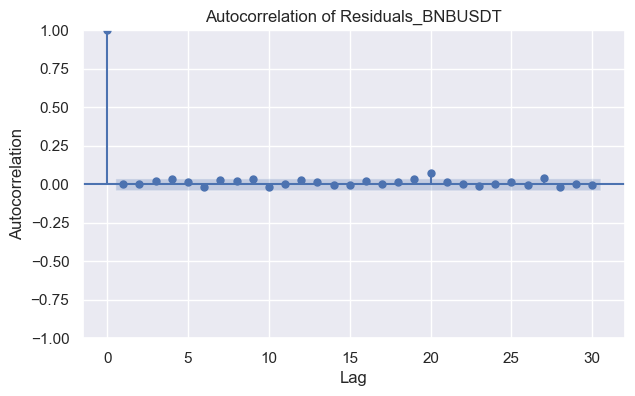

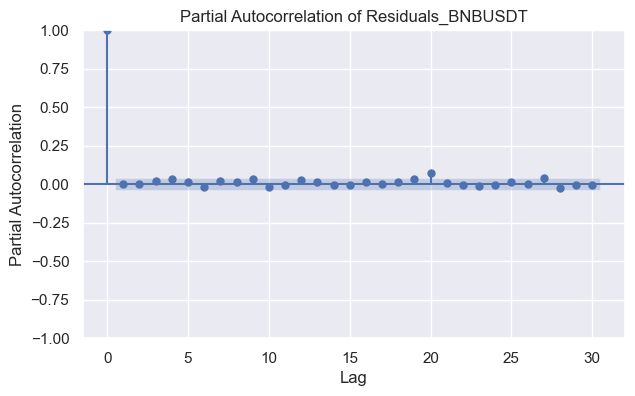

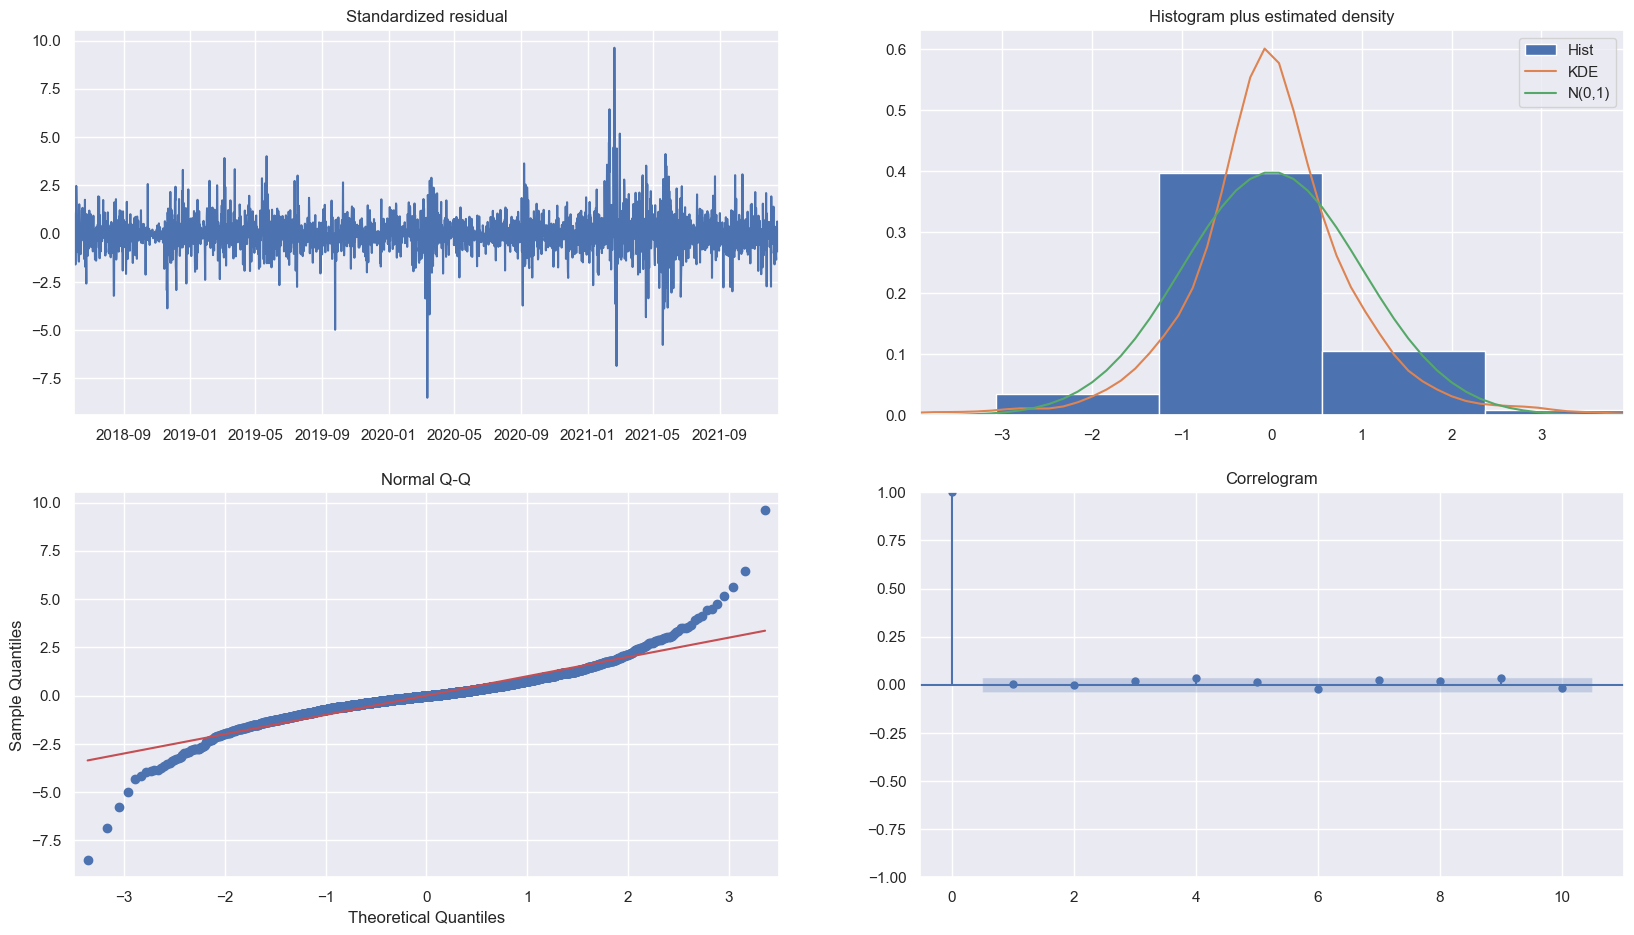

In [19]:
analyze_residuals(model_arima_bnb, 'BNBUSDT')

In [20]:
model_arima_bnb_exog = fit_auto(df, 'BNBUSDT', exogenous= ['Ret_BTCUSDT', 'Ret_ADAUSDT', 'Ret_ETHUSDT'])

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2592
Model:               SARIMAX(5, 0, 0)   Log Likelihood               -6094.465
Date:                Thu, 29 Jun 2023   AIC                          12210.929
Time:                        12:13:17   BIC                          12275.391
Sample:                    06-01-2018   HQIC                         12234.289
                         - 12-18-2021                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept       0.0631      0.108      0.585      0.558      -0.148       0.274
drift          1.6e-05   7.05e-05      0.227      0.820      -0.000       0.000
Ret_BTCUSDT     0.3600      0.026     13.739    

                 0
count  2592.000000
mean      0.000187
std       2.540869
min     -13.472579
25%      -1.230003
50%      -0.198756
75%       0.896538
max      33.653286
Residual Analysis:

Ljung-Box (lag 1) p-value: 0.9709743058016689

Jarque-Bera p-value: 0.0

Heteroskedasticity p-value: 2.78345921210893e-67

ADF p-value: 0.0




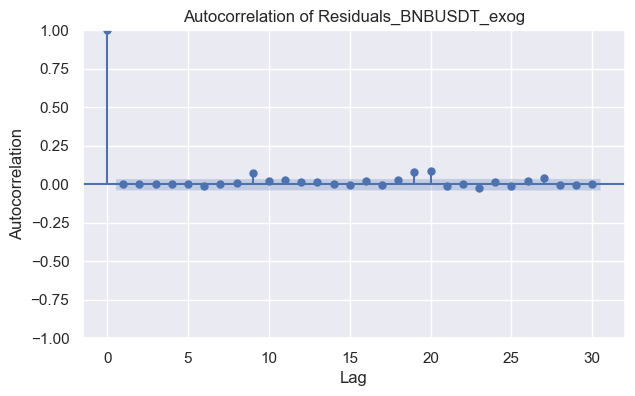

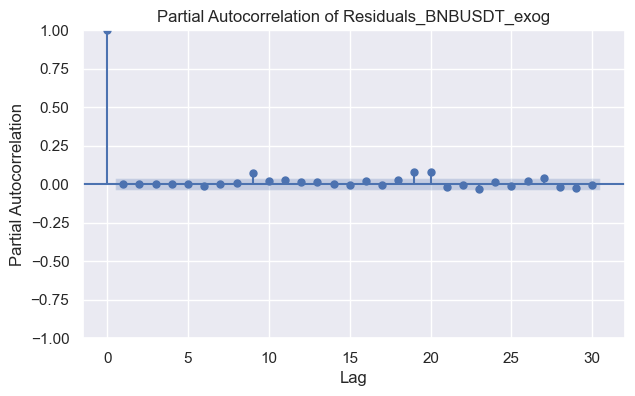

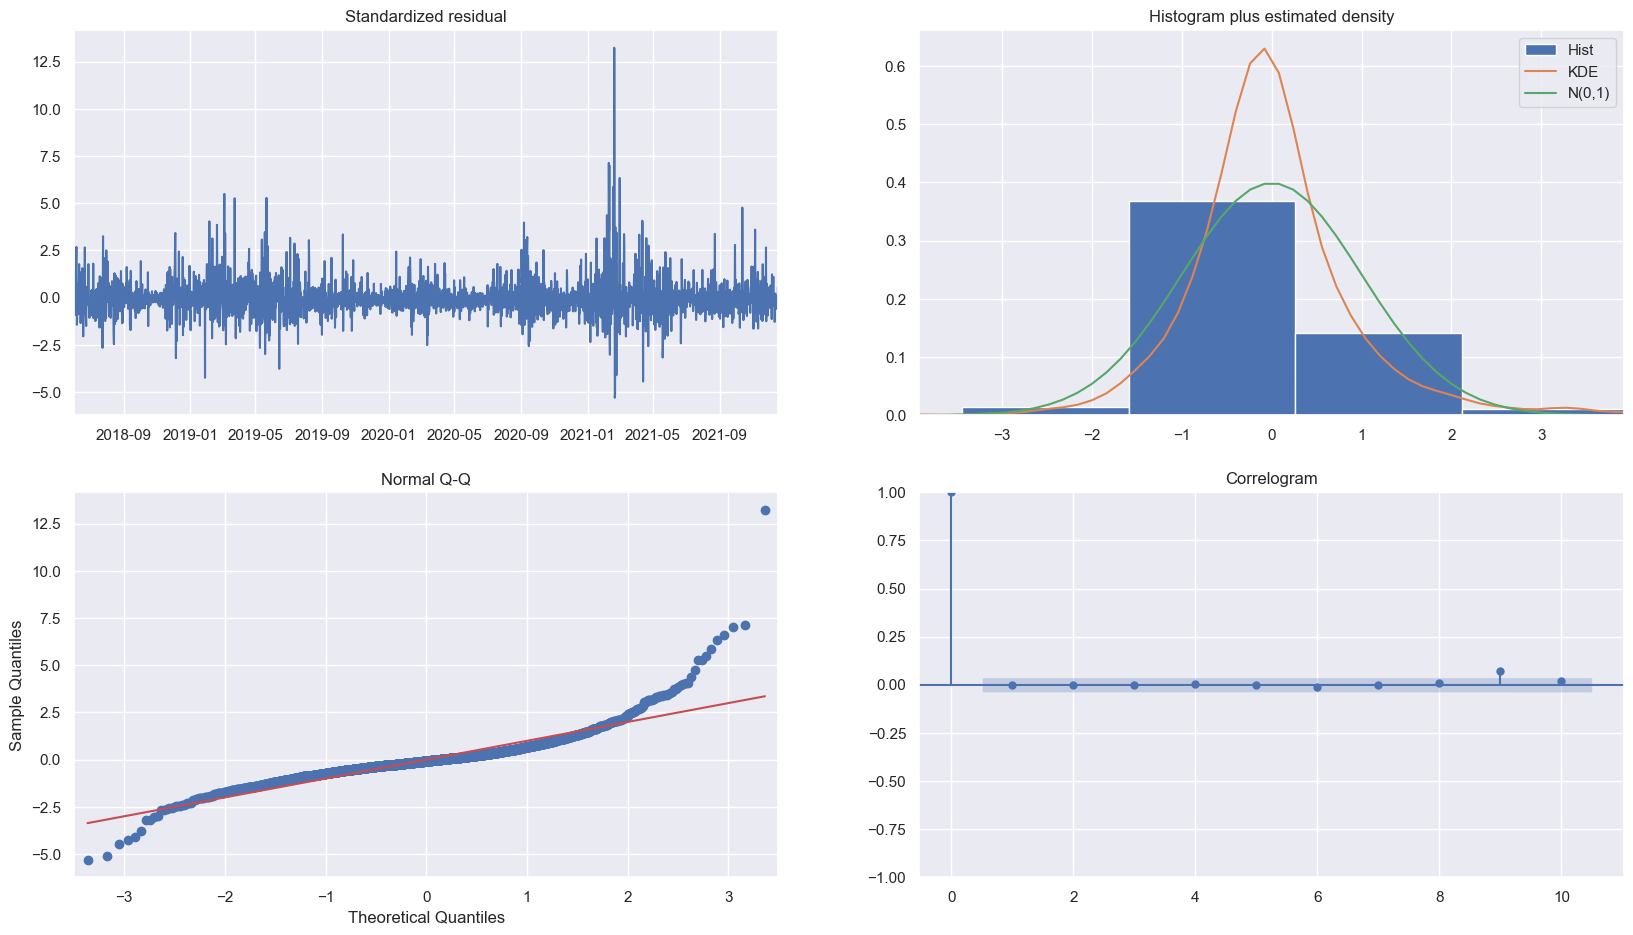

In [21]:
analyze_residuals(model_arima_bnb_exog, 'BNBUSDT_exog')

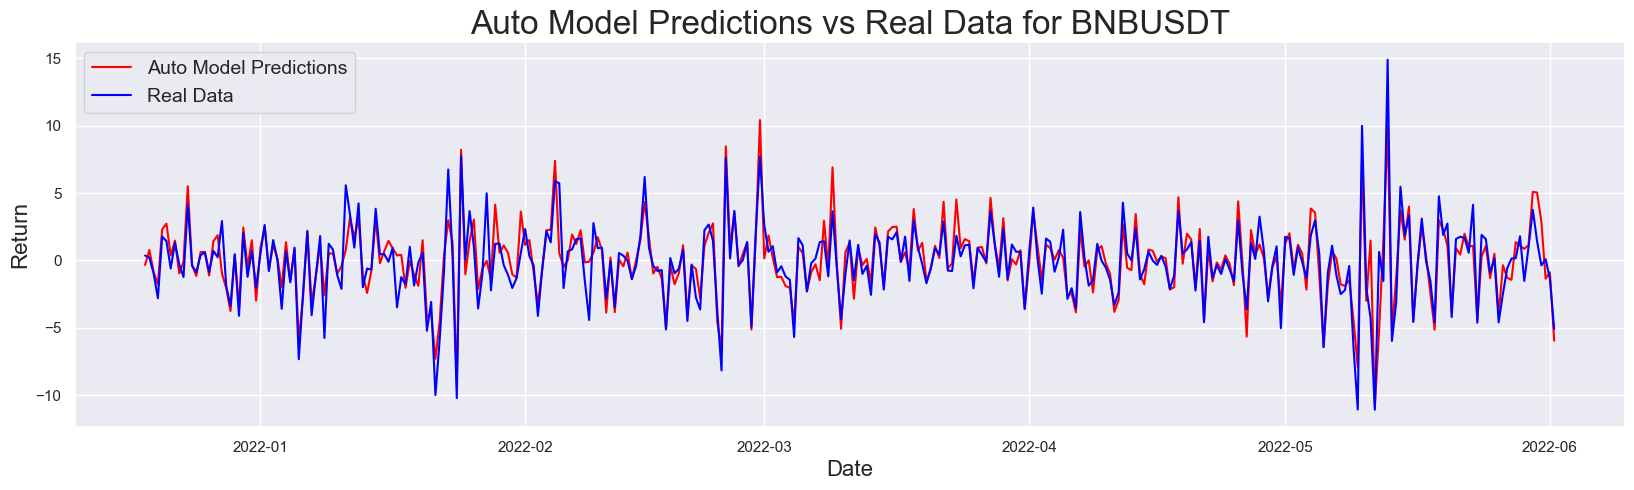

In [22]:
fit_pred(model_arima_bnb_exog, 'BNBUSDT', exogenous= ['Ret_BTCUSDT', 'Ret_ADAUSDT', 'Ret_ETHUSDT'] )

In [23]:
model_arima_btc = fit_auto(df, 'BTCUSDT', exog=False)


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2592
Model:               SARIMAX(0, 0, 2)   Log Likelihood               -6205.835
Date:                Thu, 29 Jun 2023   AIC                          12421.670
Time:                        12:13:55   BIC                          12450.971
Sample:                    06-01-2018   HQIC                         12432.288
                         - 12-18-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0041      0.112      0.037      0.971      -0.215       0.224
drift       7.923e-05   6.94e-05      1.141      0.254   -5.69e-05       0.000
ma.L1          0.0512      0.011      4.688      0.0

                 0
count  2592.000000
mean      0.000883
std       2.652434
min     -23.776324
25%      -1.039865
50%       0.034647
75%       1.028928
max      17.298787
Residual Analysis:

Ljung-Box (lag 1) p-value: 0.9728255007924227

Jarque-Bera p-value: 0.0

Heteroskedasticity p-value: 1.6507209100506593e-53

ADF p-value: 0.0




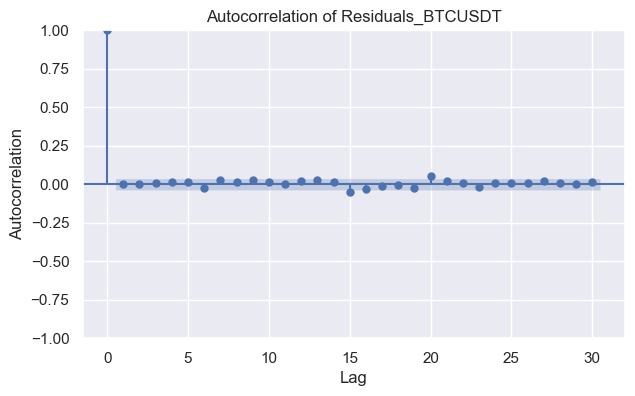

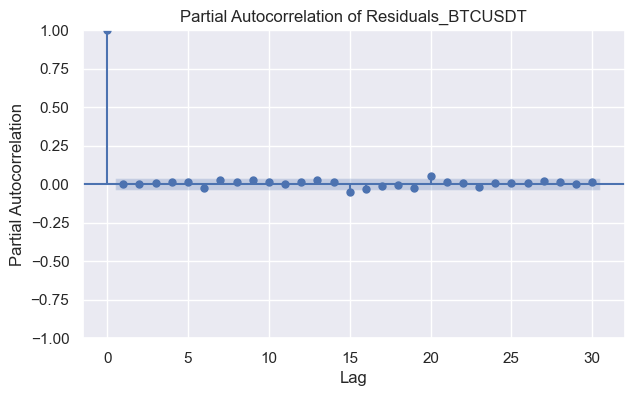

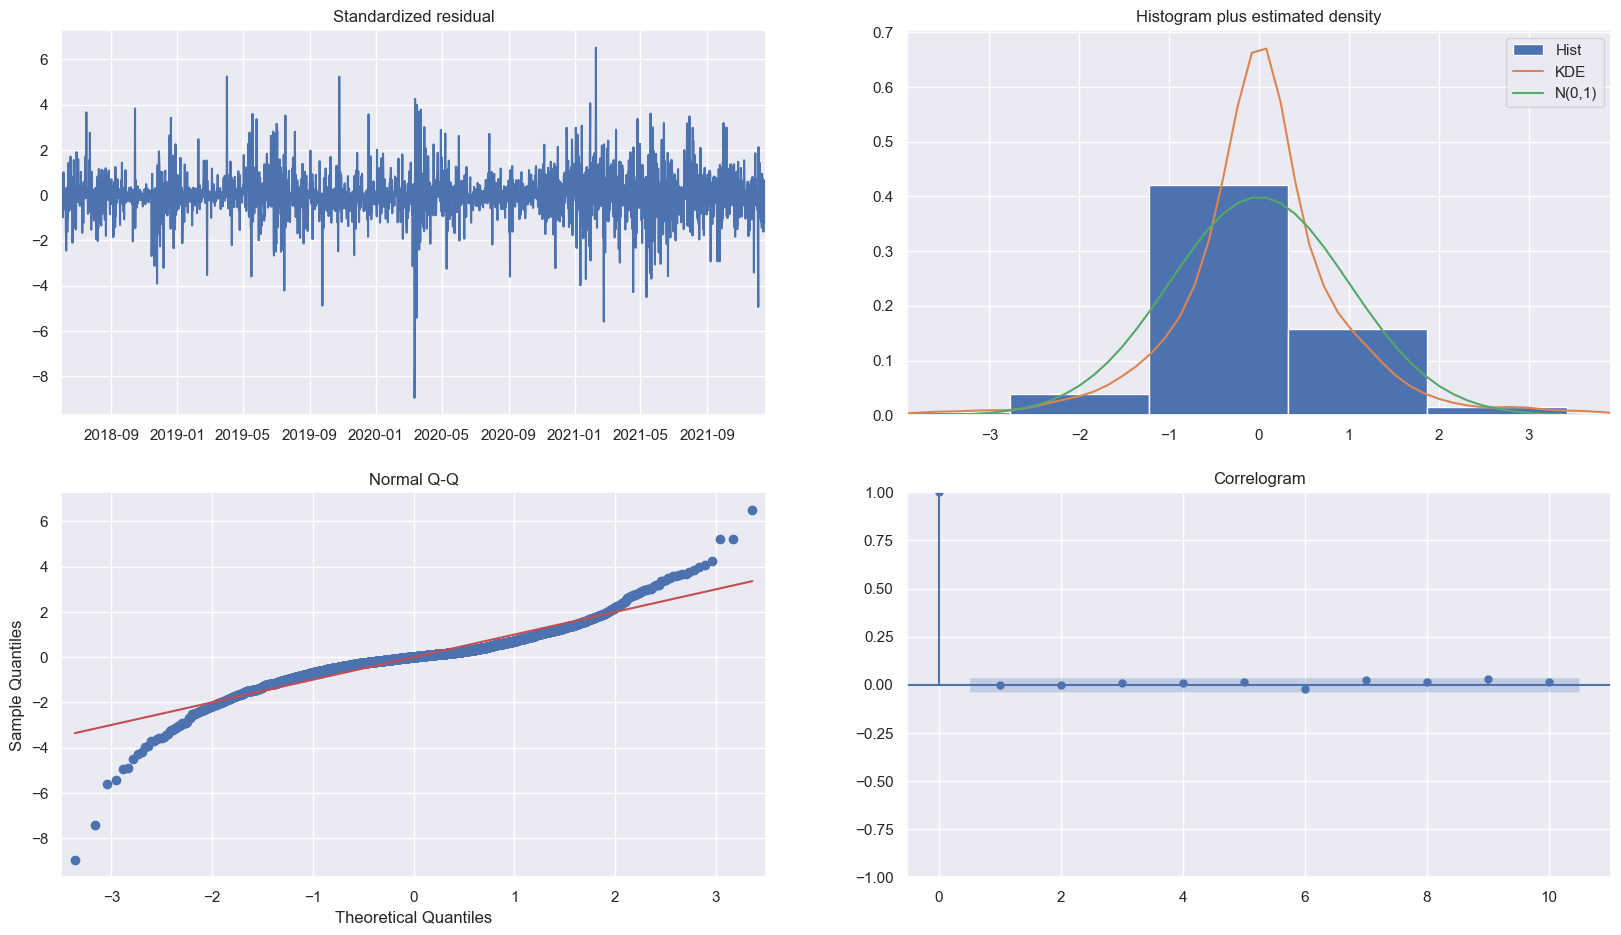

In [24]:
analyze_residuals(model_arima_btc, 'BTCUSDT')

In [25]:
model_arima_btc_exog = fit_auto(df, 'BTCUSDT', exogenous= ['Ret_BNBUSDT', "Ret_ETHUSDT", 'Ret_ADAUSDT'])


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2592
Model:               SARIMAX(0, 0, 1)   Log Likelihood               -4743.635
Date:                Thu, 29 Jun 2023   AIC                           9501.270
Time:                        12:14:37   BIC                           9542.291
Sample:                    06-01-2018   HQIC                          9516.135
                         - 12-18-2021                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept       0.0886      0.074      1.195      0.232      -0.057       0.234
drift       -6.454e-05   4.58e-05     -1.408      0.159      -0.000    2.53e-05
Ret_BNBUSDT     0.1228      0.008     15.339    

                 0
count  2592.000000
mean      0.002224
std       1.508866
min     -13.718343
25%      -0.662893
50%      -0.039687
75%       0.615105
max      14.090610
Residual Analysis:

Ljung-Box (lag 1) p-value: 0.9988487367818375

Jarque-Bera p-value: 0.0

Heteroskedasticity p-value: 2.9452294353070785e-13

ADF p-value: 0.0




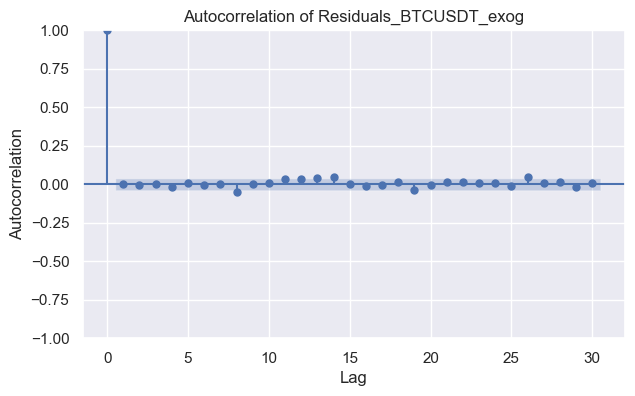

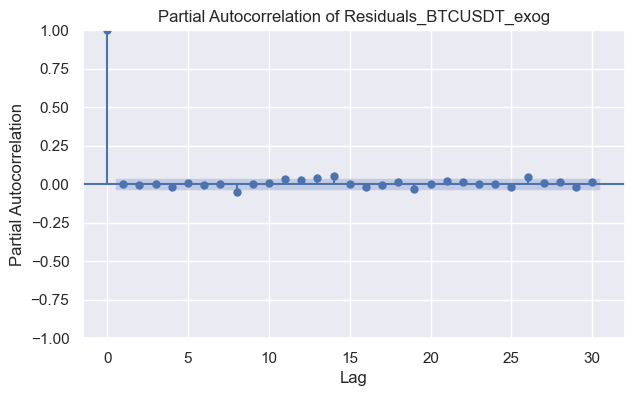

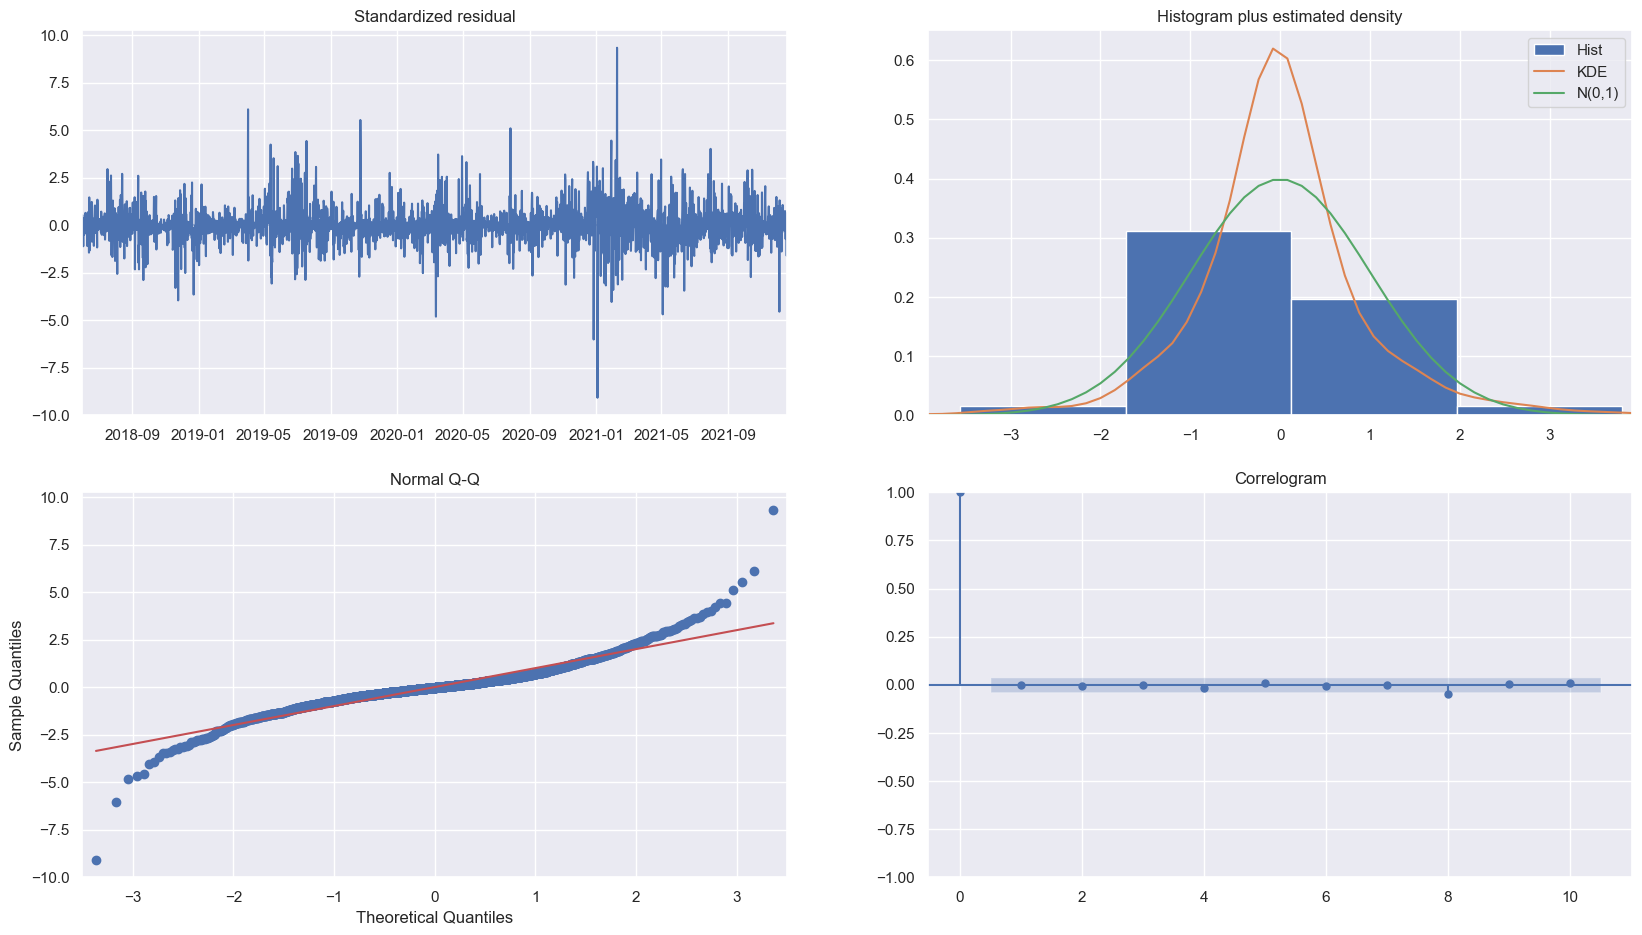

In [26]:
analyze_residuals(model_arima_btc_exog, 'BTCUSDT_exog')

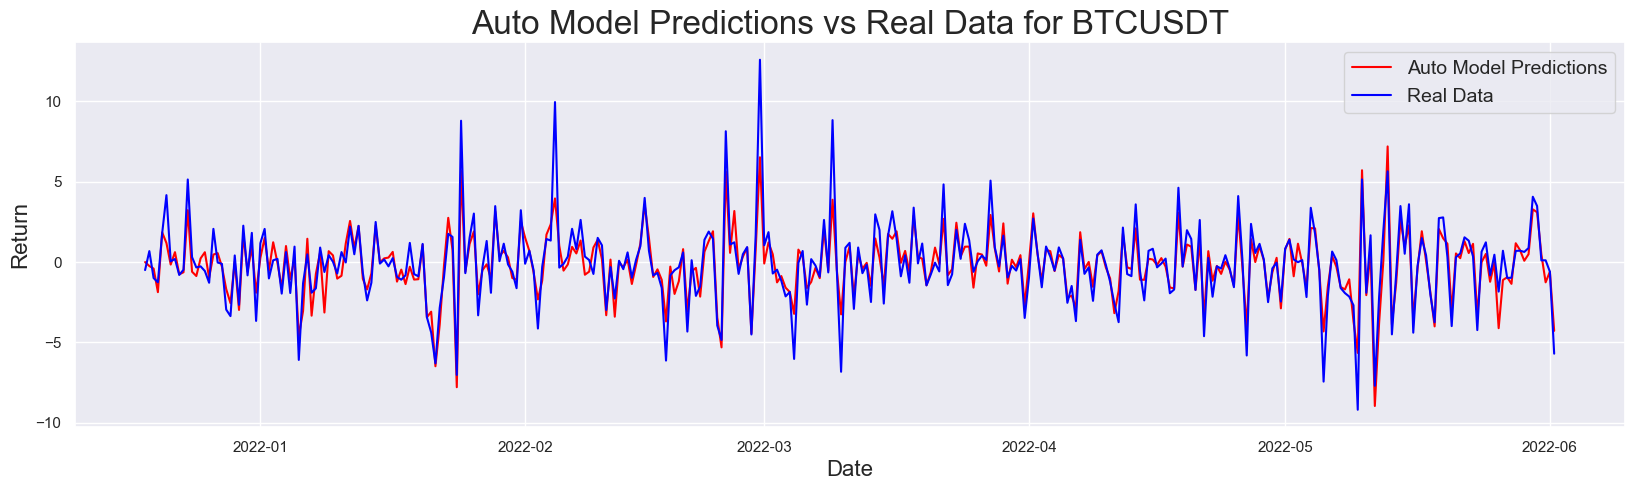

In [27]:
fit_pred(model_arima_btc_exog, 'BTCUSDT', exogenous= ['Ret_BNBUSDT', "Ret_ETHUSDT", 'Ret_ADAUSDT'] )

In [28]:


model_arima_ada = fit_auto(df, 'ADAUSDT', exog=False)


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2592
Model:               SARIMAX(0, 1, 5)   Log Likelihood               -7322.288
Date:                Thu, 29 Jun 2023   AIC                          14660.575
Time:                        12:15:58   BIC                          14707.454
Sample:                    06-01-2018   HQIC                         14677.563
                         - 12-18-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0098      0.004      2.219      0.027       0.001       0.019
drift      -6.839e-06   2.88e-06     -2.378      0.017   -1.25e-05    -1.2e-06
ma.L1         -0.8832      0.016    -56.904      0.0

                 0
count  2592.000000
mean     -0.056444
std       4.079430
min     -29.703929
25%      -2.033429
50%      -0.190451
75%       1.838509
max      22.889457
Residual Analysis:

Ljung-Box (lag 1) p-value: 0.0012026015535582908

Jarque-Bera p-value: 0.0

Heteroskedasticity p-value: 1.4490184559264293e-28

ADF p-value: 0.0




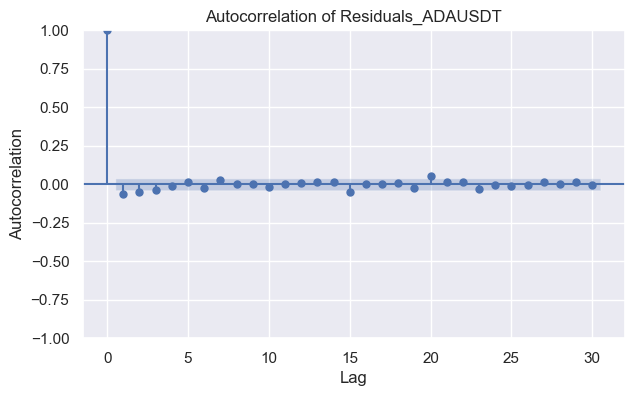

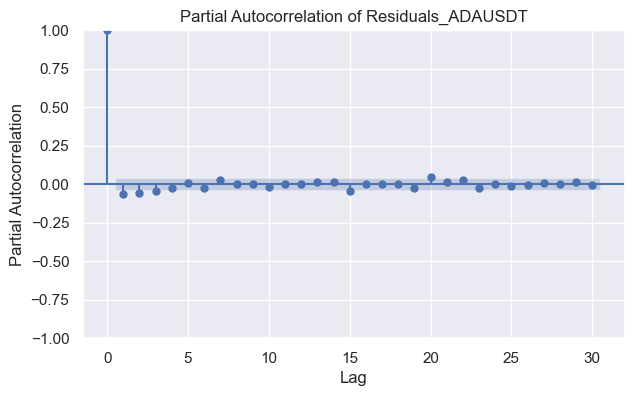

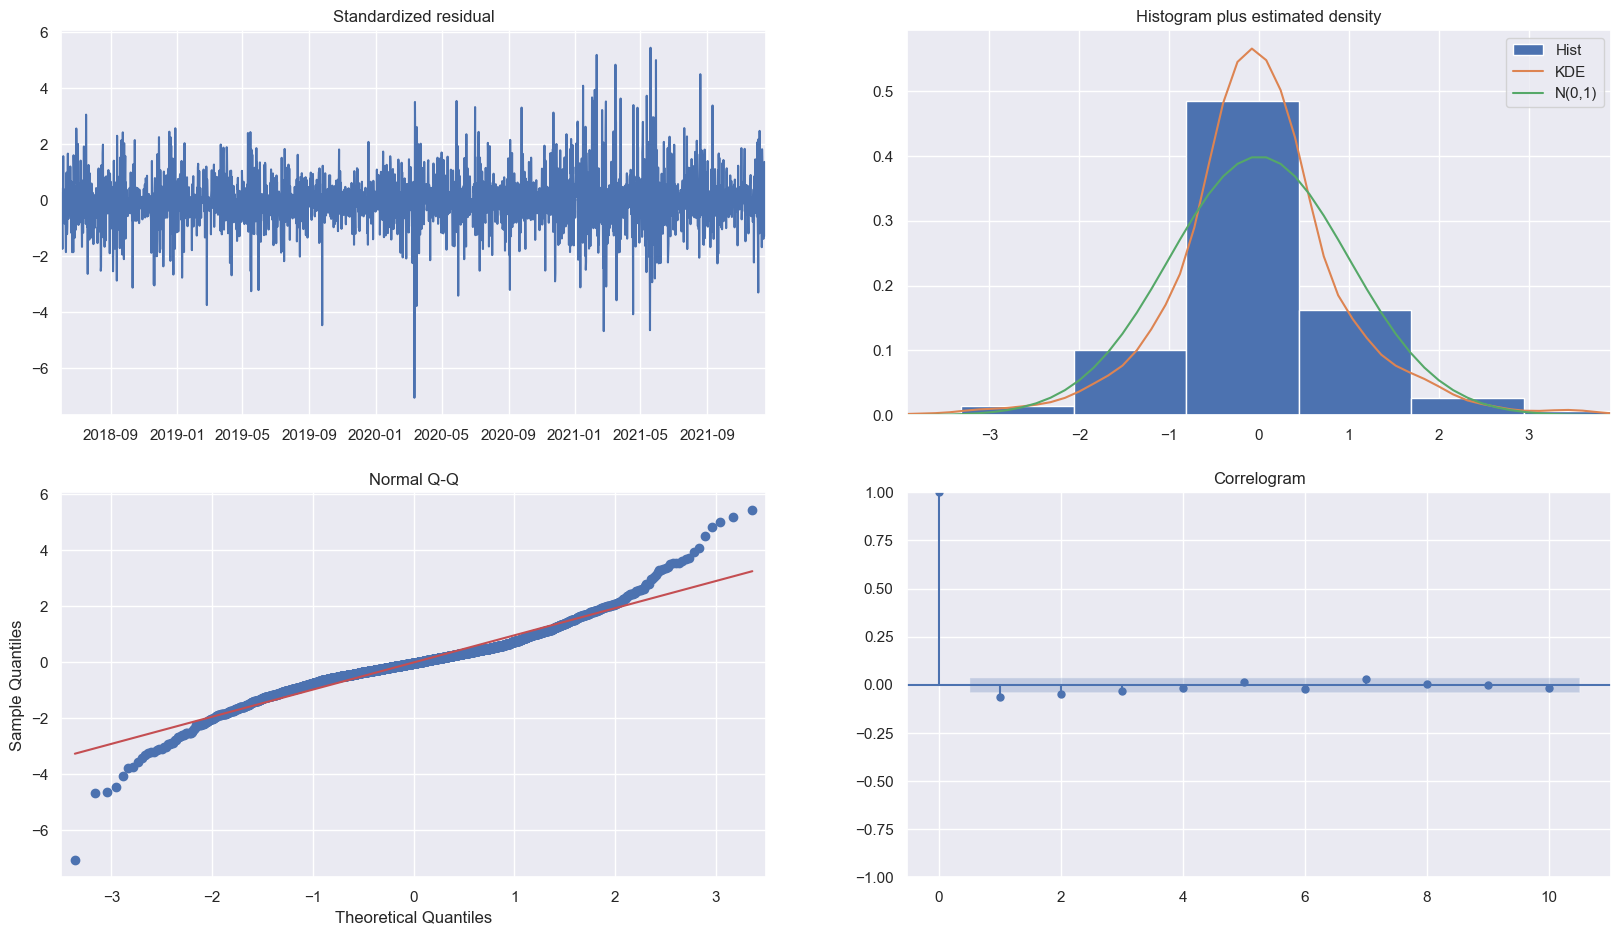

In [29]:
analyze_residuals(model_arima_ada, 'ADAUSDT')

In [30]:
model_arima_ada_exog = fit_auto(df, 'ADAUSDT', exogenous=['Ret_BTCUSDT', 'Ret_ETHUSDT', 'Ret_BNBUSDT'])


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2592
Model:               SARIMAX(0, 0, 1)   Log Likelihood               -6127.400
Date:                Thu, 29 Jun 2023   AIC                          12268.800
Time:                        12:16:38   BIC                          12309.821
Sample:                    06-01-2018   HQIC                         12283.665
                         - 12-18-2021                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept      -0.0585      0.139     -0.421      0.674      -0.331       0.214
drift        4.727e-05   8.16e-05      0.579      0.562      -0.000       0.000
Ret_BTCUSDT     0.2146      0.024      9.073    

                 0
count  2592.000000
mean      0.000349
std       2.573378
min     -12.967833
25%      -1.324885
50%      -0.191984
75%       0.889473
max      19.448952
Residual Analysis:

Ljung-Box (lag 1) p-value: 0.9956717218523251

Jarque-Bera p-value: 0.0

Heteroskedasticity p-value: 1.3310543282414287e-51

ADF p-value: 0.0




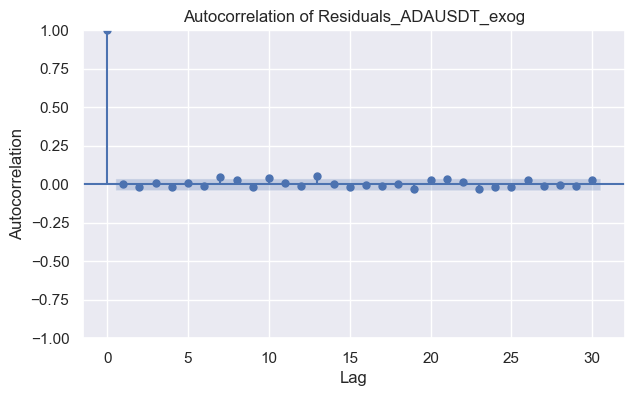

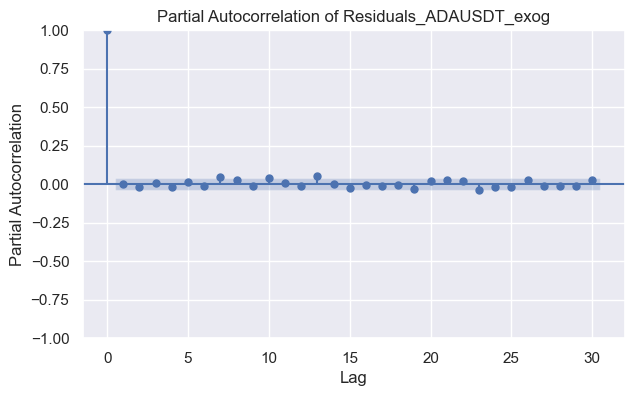

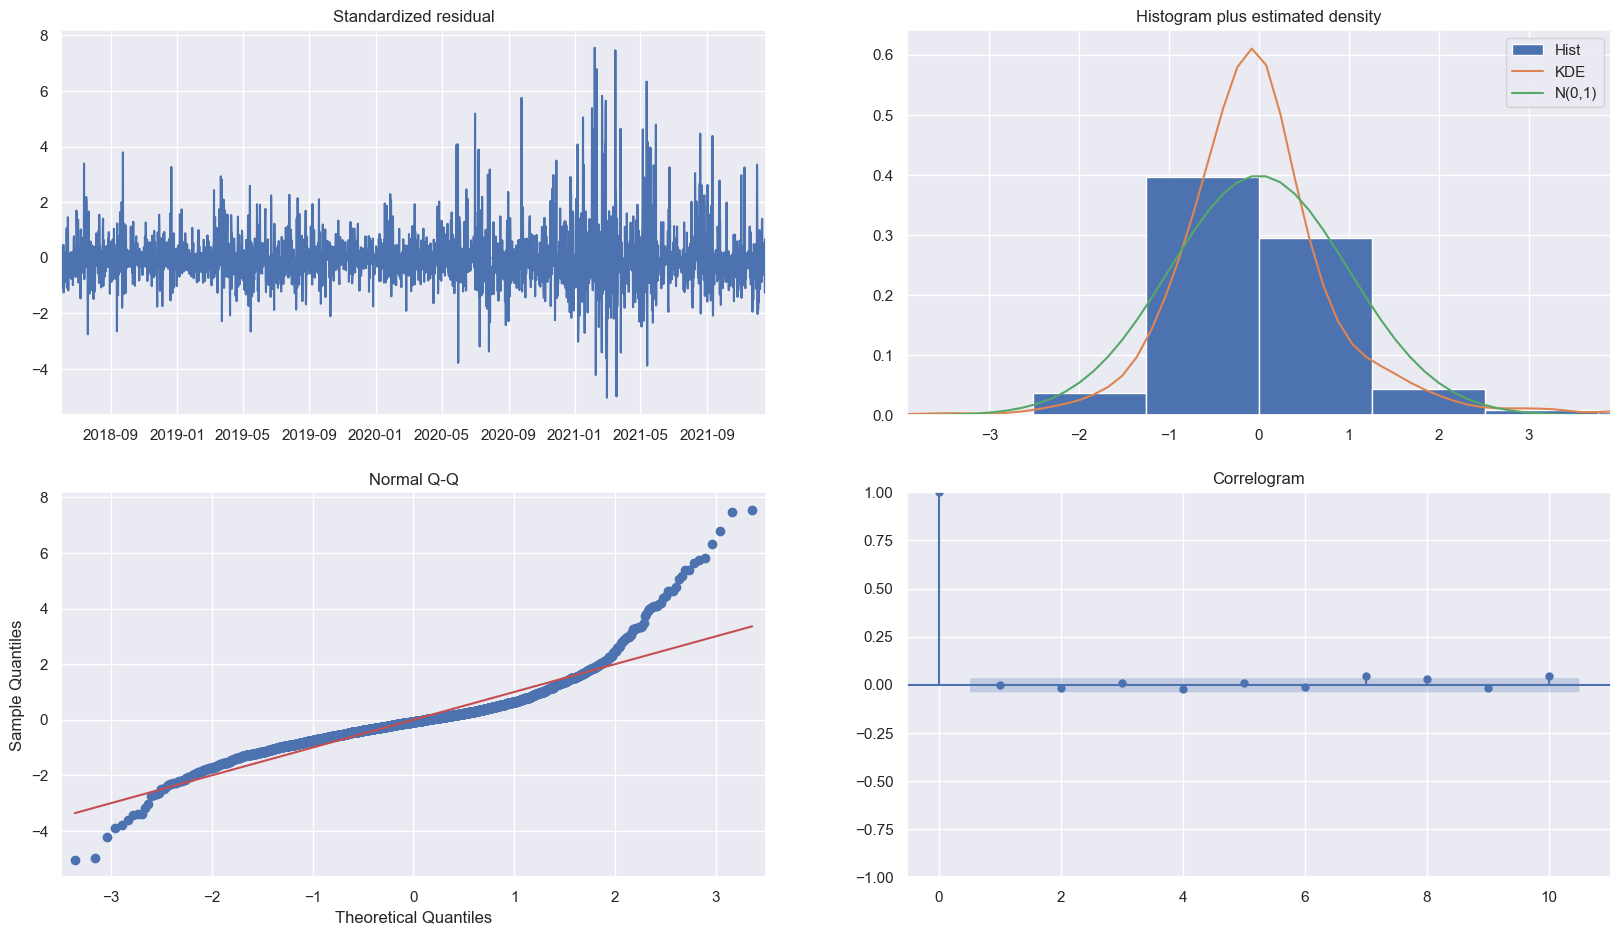

In [31]:
analyze_residuals(model_arima_ada_exog, 'ADAUSDT_exog')

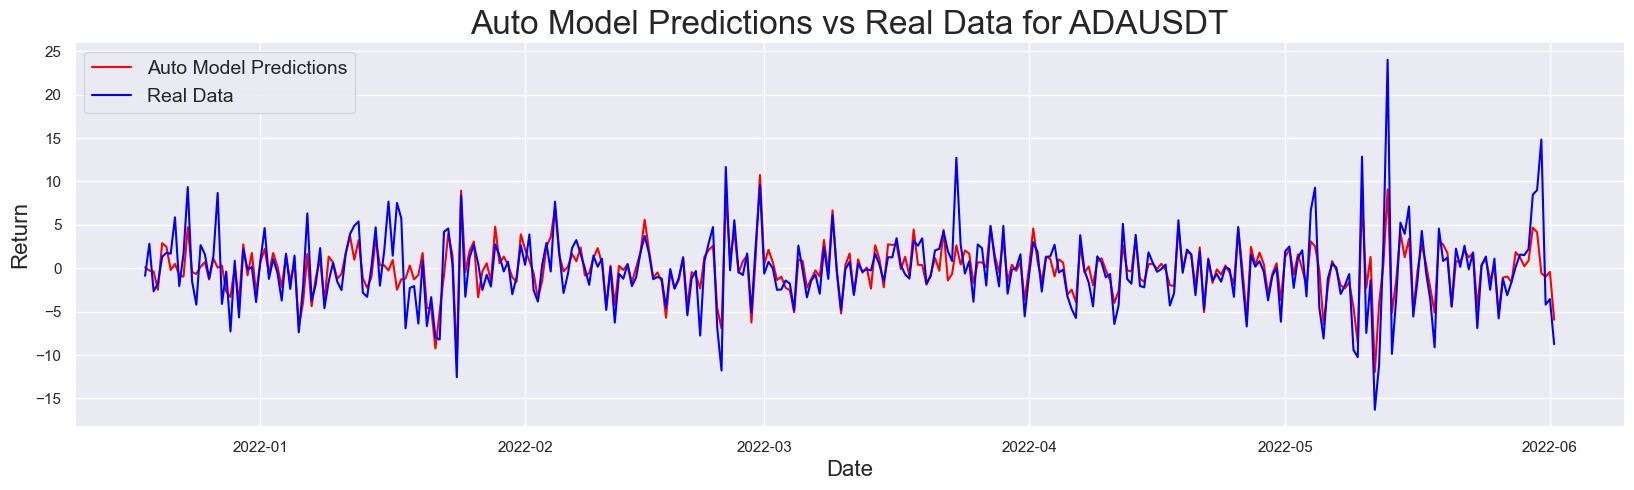

In [32]:
fit_pred(model_arima_ada_exog, 'ADAUSDT', exogenous=['Ret_BTCUSDT', 'Ret_ETHUSDT', 'Ret_BNBUSDT'])

In [33]:

model_arima_eth = fit_auto(df, 'ETHUSDT', exog=False)


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2592
Model:               SARIMAX(0, 1, 4)   Log Likelihood               -6900.697
Date:                Thu, 29 Jun 2023   AIC                          13815.394
Time:                        12:18:37   BIC                          13856.413
Sample:                    06-01-2018   HQIC                         13830.259
                         - 12-18-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -3.961e-05      0.008     -0.005      0.996      -0.016       0.016
drift      -3.552e-07   5.07e-06     -0.070      0.944   -1.03e-05    9.58e-06
ma.L1         -0.8650      0.013    -64.518      0.0

                 0
count  2592.000000
mean      0.005349
std       3.466415
min     -29.192620
25%      -1.487099
50%      -0.042985
75%       1.556170
max      21.088147
Residual Analysis:

Ljung-Box (lag 1) p-value: 0.0005161000851650652

Jarque-Bera p-value: 0.0

Heteroskedasticity p-value: 1.3676721077124925e-51

ADF p-value: 0.0




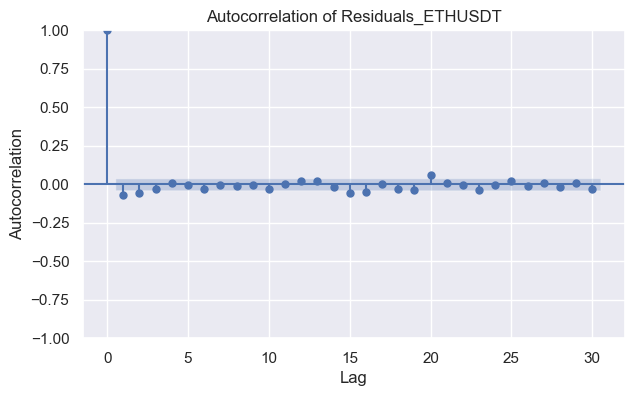

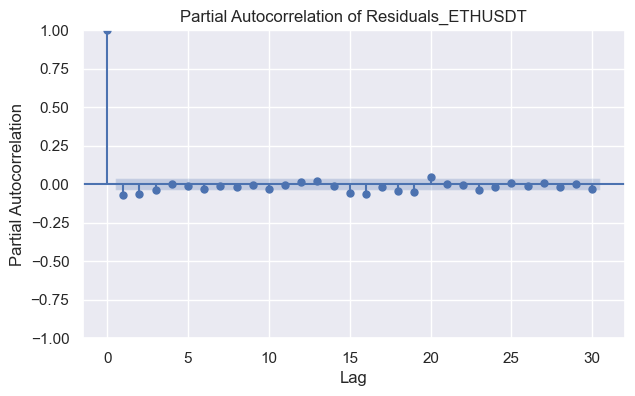

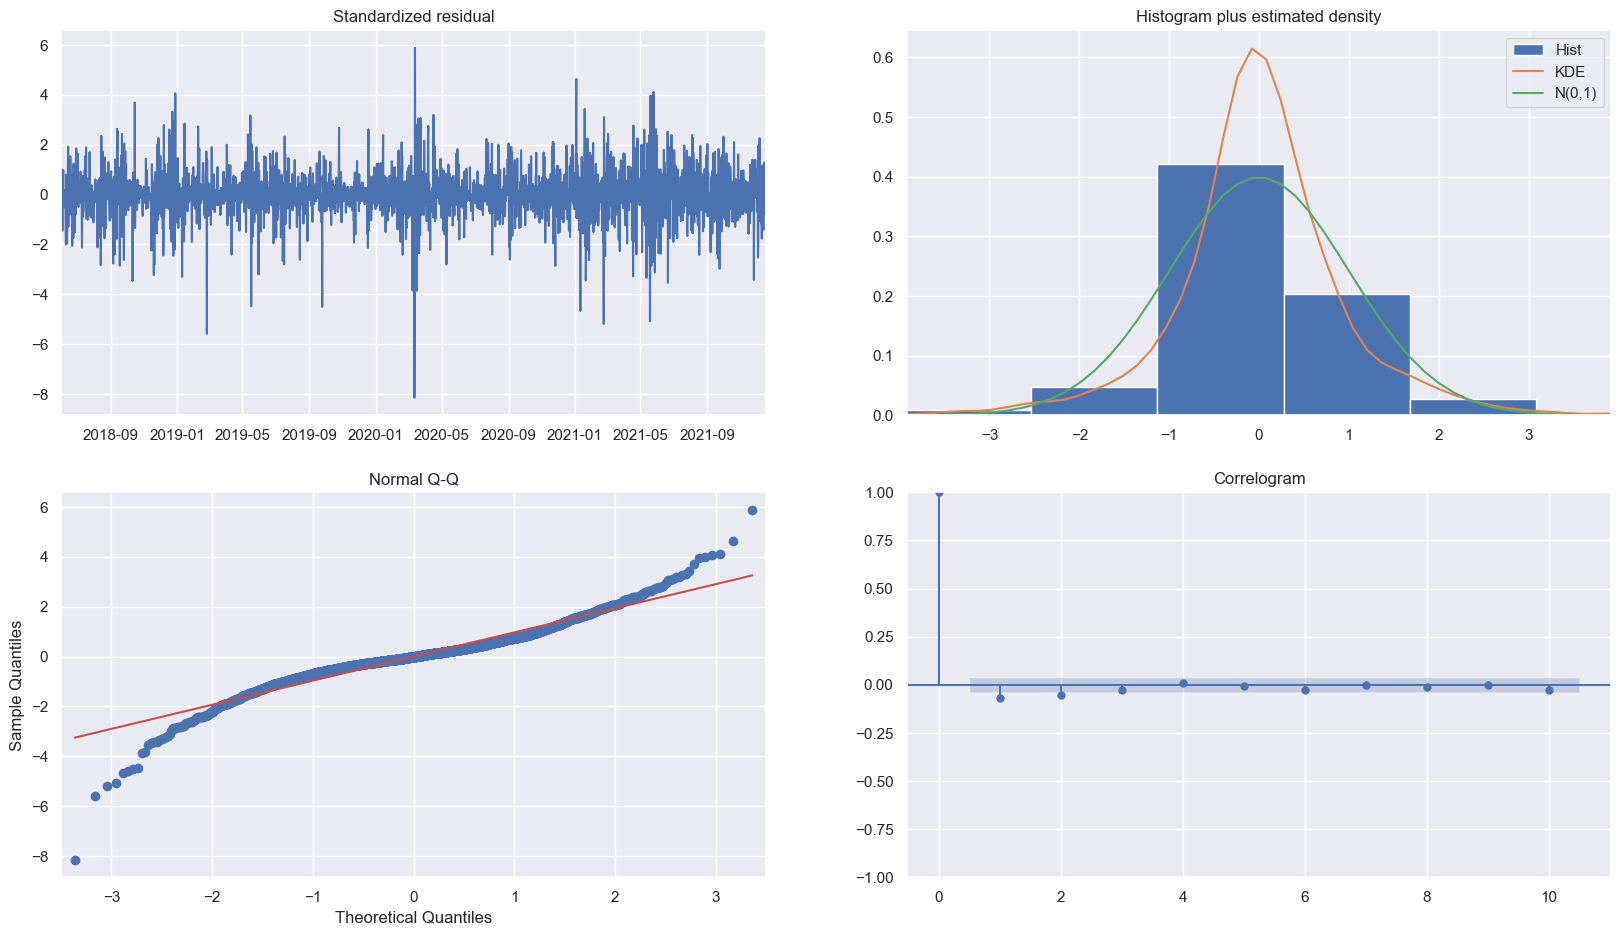

In [34]:
analyze_residuals(model_arima_eth, 'ETHUSDT')

In [35]:
model_arima_eth_exog = fit_auto(df, 'ETHUSDT', exogenous=['Ret_BTCUSDT', 'Ret_BNBUSDT', 'Ret_ADAUSDT'])

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2592
Model:               SARIMAX(3, 0, 0)   Log Likelihood               -5094.692
Date:                Thu, 29 Jun 2023   AIC                          10207.385
Time:                        12:19:21   BIC                          10260.127
Sample:                    06-01-2018   HQIC                         10226.498
                         - 12-18-2021                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept      -0.1082      0.076     -1.422      0.155      -0.257       0.041
drift        7.985e-05   4.65e-05      1.717      0.086   -1.13e-05       0.000
Ret_BTCUSDT     0.6099      0.011     55.495    

                 0
count  2592.000000
mean     -0.000263
std       1.727712
min      -8.707345
25%      -0.854268
50%      -0.072341
75%       0.634941
max      17.296564
Residual Analysis:

Ljung-Box (lag 1) p-value: 0.9572779336464502

Jarque-Bera p-value: 0.0

Heteroskedasticity p-value: 9.67260472973527e-08

ADF p-value: 0.0




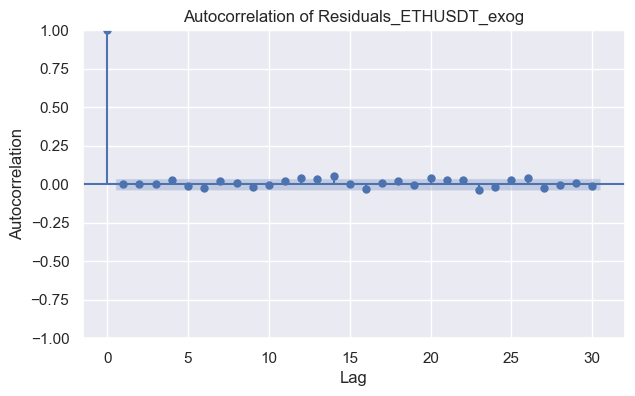

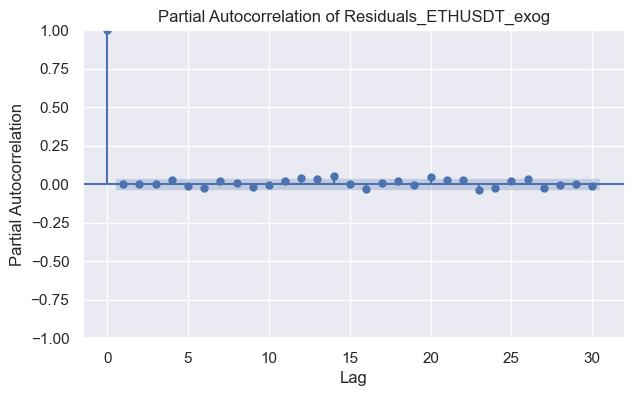

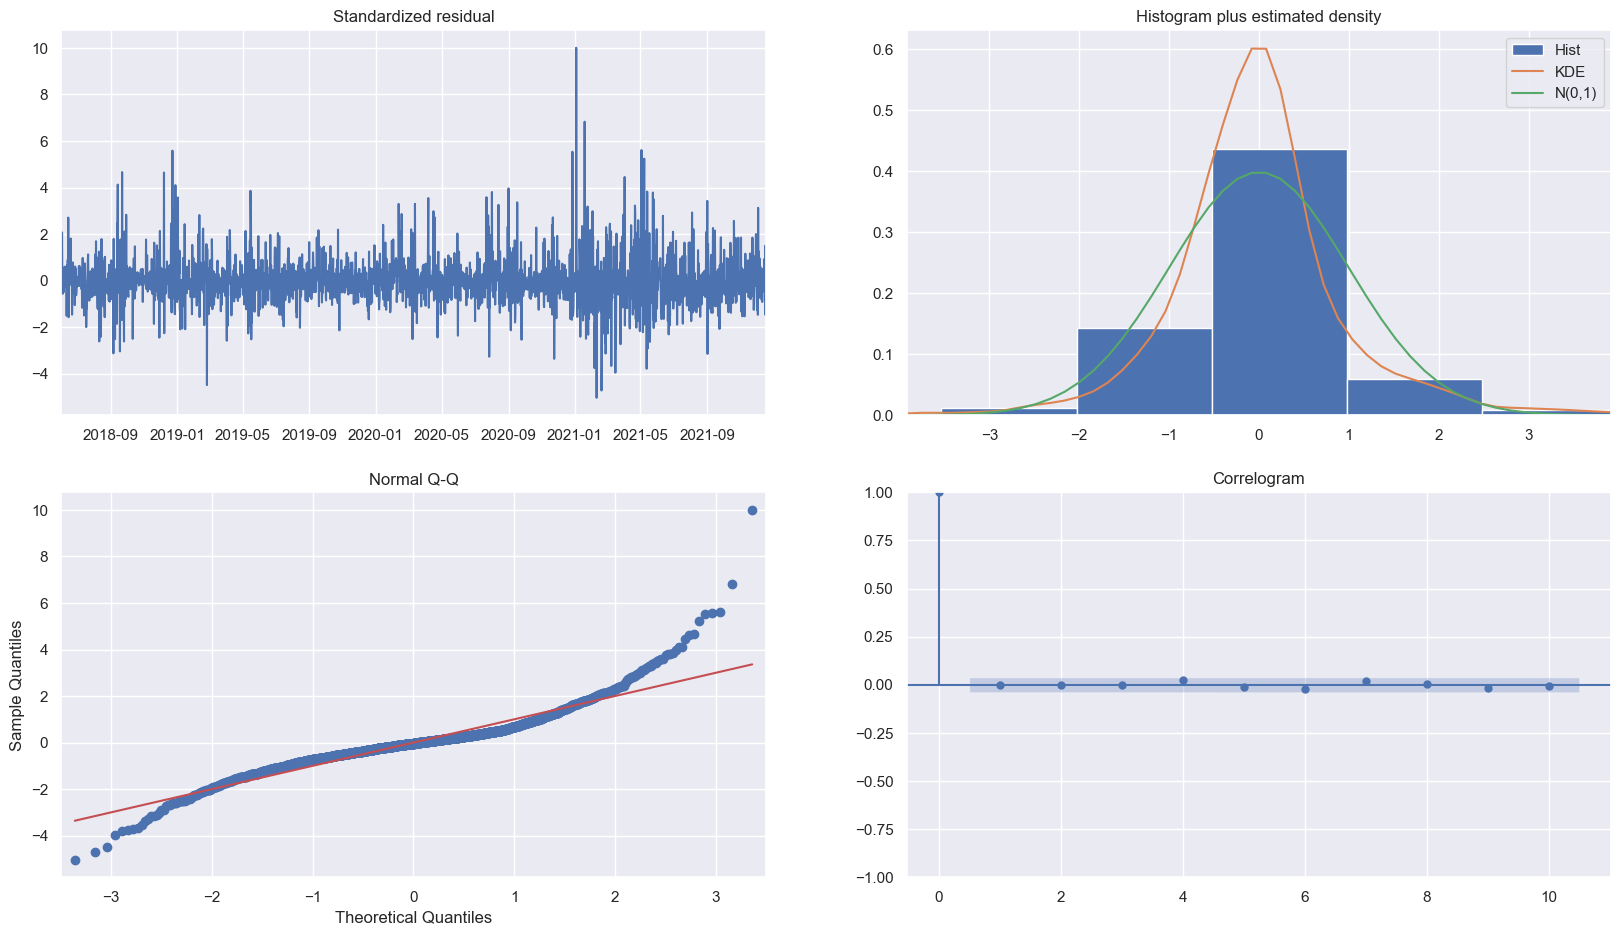

In [36]:
analyze_residuals(model_arima_eth_exog, 'ETHUSDT_exog')

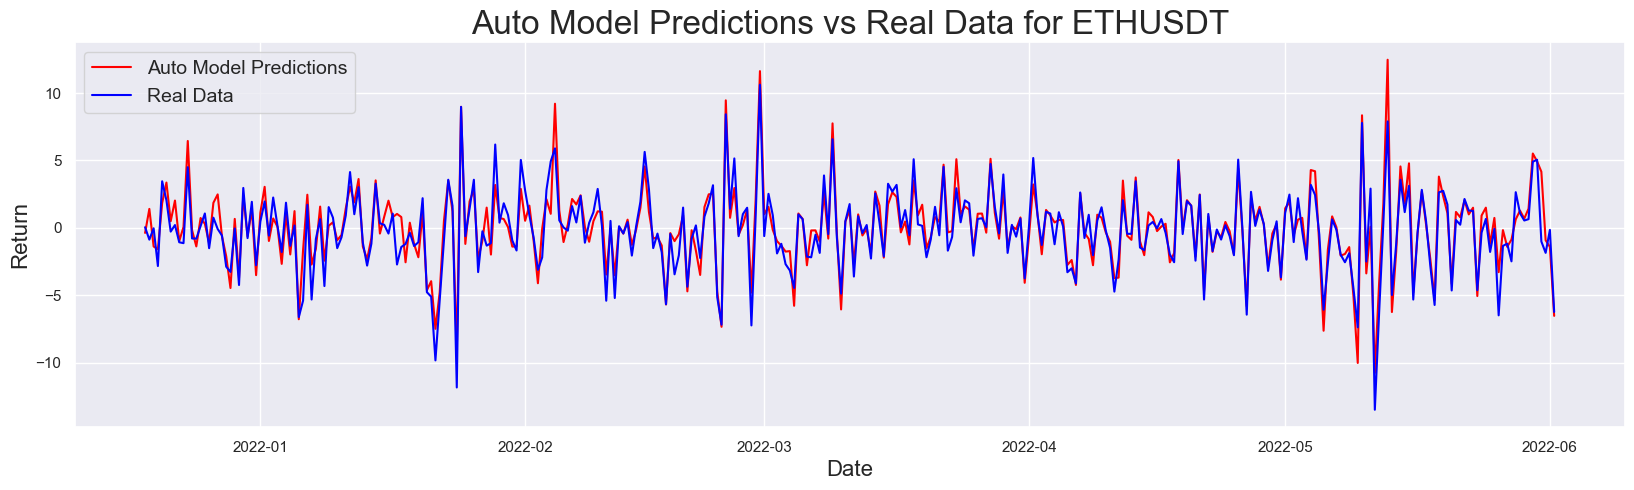

In [37]:
fit_pred(model_arima_eth_exog, 'ETHUSDT', exogenous=['Ret_BTCUSDT', 'Ret_BNBUSDT', 'Ret_ADAUSDT'] )

##### Forcasting Volitilty 

In [38]:
df_test.head()[start_date:]

,BTCUSDT,ETHUSDT,ADAUSDT,BNBUSDT,Ret_BTCUSDT,Ret_cum_BTCUSDT,Norm_BTCUSDT,Ret_ETHUSDT,Ret_cum_ETHUSDT,Norm_ETHUSDT,Ret_ADAUSDT,Ret_cum_ADAUSDT,Norm_ADAUSDT,Ret_BNBUSDT,Ret_cum_BNBUSDT,Norm_BNBUSDT
Date,,,,,,,,,,,,,,,,
2021-12-18 12:00:00,46834.48,3959.93,1.242,533.9,-0.501291,278.249627,636.217888,0.045476,349.537959,693.957556,-0.877893,389.675144,575.532901,0.357143,552.756524,3874.455733
2021-12-19 00:00:00,47152.72,3925.36,1.277,535.0,0.679499,278.929126,640.540985,-0.872995,348.664963,687.899339,2.818035,392.493179,591.751622,0.206031,552.962555,3882.438316
2021-12-19 12:00:00,46681.23,3924.14,1.243,529.8,-0.999921,277.929205,634.136080,-0.031080,348.633884,687.685541,-2.662490,389.830689,575.996293,-0.971963,551.990592,3844.702467
2021-12-20 00:00:00,46092.60,3813.02,1.221,514.9,-1.260956,276.668249,626.139900,-2.831703,345.802180,668.212327,-1.769912,388.060778,565.801668,-2.812382,549.178210,3736.574746
2021-12-20 12:00:00,46914.16,3944.73,1.237,524.0,1.782412,278.450661,637.300292,3.454217,349.256398,691.293833,1.310401,389.371179,573.215941,1.767333,550.945544,3802.612482


In [39]:

df_com = pd.concat([df, df_test])

In [40]:
df_com.tail()

,BTCUSDT,ETHUSDT,ADAUSDT,BNBUSDT,Ret_BTCUSDT,Ret_cum_BTCUSDT,Norm_BTCUSDT,Ret_ETHUSDT,Ret_cum_ETHUSDT,Norm_ETHUSDT,Ret_ADAUSDT,Ret_cum_ADAUSDT,Norm_ADAUSDT,Ret_BNBUSDT,Ret_cum_BNBUSDT,Norm_BNBUSDT
Date,,,,,,,,,,,,,,,,
2023-06-25 00:00:00,30716.03,1918.37,0.2981,240.2,0.617805,262.724610,417.258561,2.315249,321.074468,336.184568,3.077455,305.644200,138.137164,1.607445,506.181376,1743.105951
2023-06-25 12:00:00,30462.66,1898.80,0.2921,238.8,-0.824879,261.899732,413.816684,-1.020137,320.054331,332.755025,-2.012747,303.631452,135.356812,-0.582848,505.598528,1732.946299
2023-06-26 00:00:00,30322.89,1880.87,0.2890,237.9,-0.458824,261.440908,411.917994,-0.944281,319.110050,329.612884,-1.061280,302.570172,133.920297,-0.376884,505.221644,1726.415094
2023-06-26 12:00:00,30267.99,1858.97,0.2805,236.1,-0.181051,261.259856,411.172211,-1.164355,317.945696,325.775021,-2.941176,299.628996,129.981464,-0.756620,504.465023,1713.352685
2023-06-27 00:00:00,30735.98,1881.51,0.2842,239.4,1.546155,262.806011,417.529570,1.212499,319.158195,329.725041,1.319073,300.948069,131.696015,1.397713,505.862736,1737.300435


In [41]:
def garch_volatility(column, df = df_com, df_test = df_test, start_date = start_date):

    model = arch.arch_model(df[f'Ret_{column}'], vol='Garch', p=1, q=1)

    # Fit the model
    results = model.fit(last_obs=start_date,  update_freq=10)
    
    #forcast 
    pred_garch = results.forecast(horizon=1, align='target')


    # Plot the estimated volatility
    fig, ax = plt.subplots(figsize=(20, 6))
    pred_garch.residual_variance[start_date:].plot(figsize = (20,5), color = "red", zorder = 2, ax = ax)
    df_test[f'Ret_{column}'].abs().plot(color = "blue", zorder = 1, ax = ax)
    plt.title("Volatility Predictions", size = 24)    
    ax.set_xlabel('Time', fontsize = 15)
    ax.set_ylabel('Volatility', fontsize = 17)
    ax.set_title(f'GARCH Estimated Volatility {column}', fontsize = 20)
    ax.legend()
    plt.savefig(f'../reports/figures/Ret_{column}_garch_forcast.png')
    plt.show()


Iteration:     10,   Func. Count:     63,   Neg. LLF: 6787.4369759566325
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6787.4369759566325
            Iterations: 11
            Function evaluations: 67
            Gradient evaluations: 11


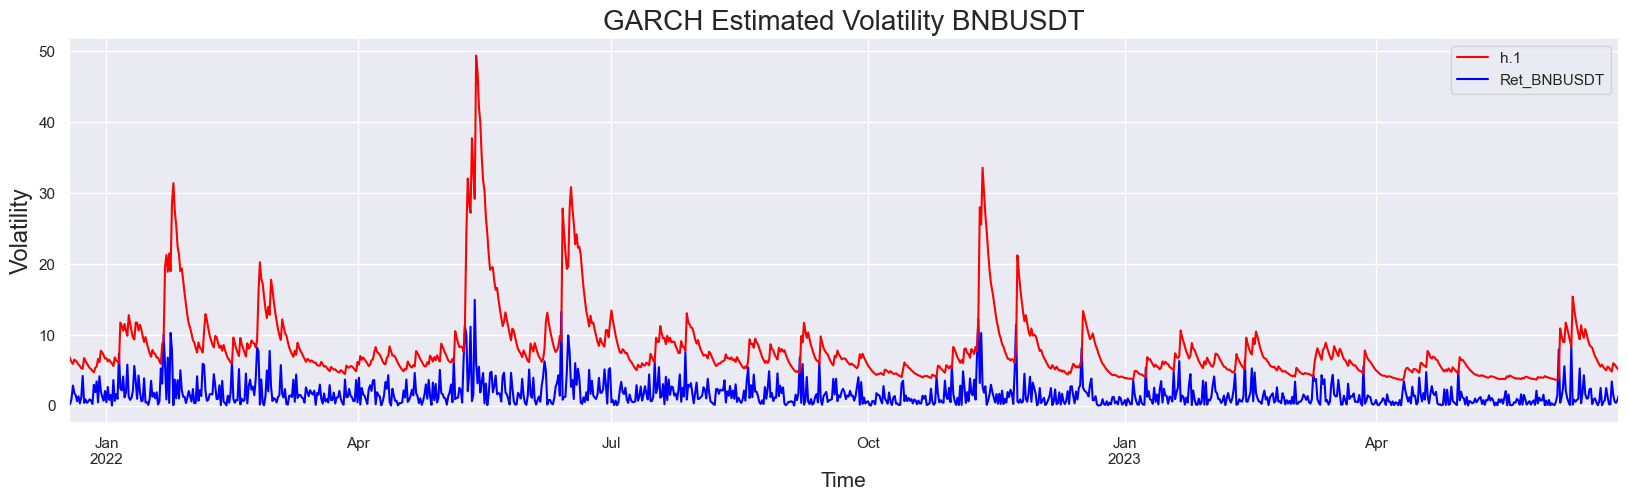

In [42]:
garch_volatility('BNBUSDT')

Iteration:     10,   Func. Count:     60,   Neg. LLF: 7151.37612664454
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7151.376082066814
            Iterations: 13
            Function evaluations: 74
            Gradient evaluations: 13


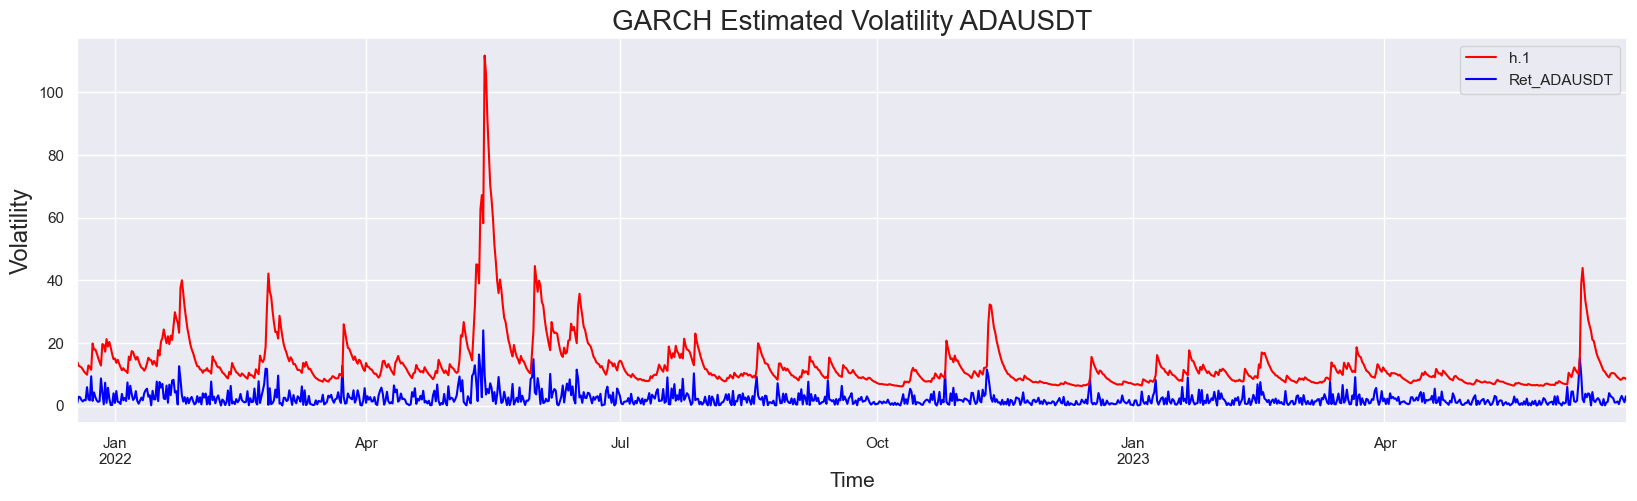

In [43]:
garch_volatility('ADAUSDT')

Iteration:     10,   Func. Count:     61,   Neg. LLF: 6708.680754873141
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6708.680717520079
            Iterations: 12
            Function evaluations: 71
            Gradient evaluations: 12


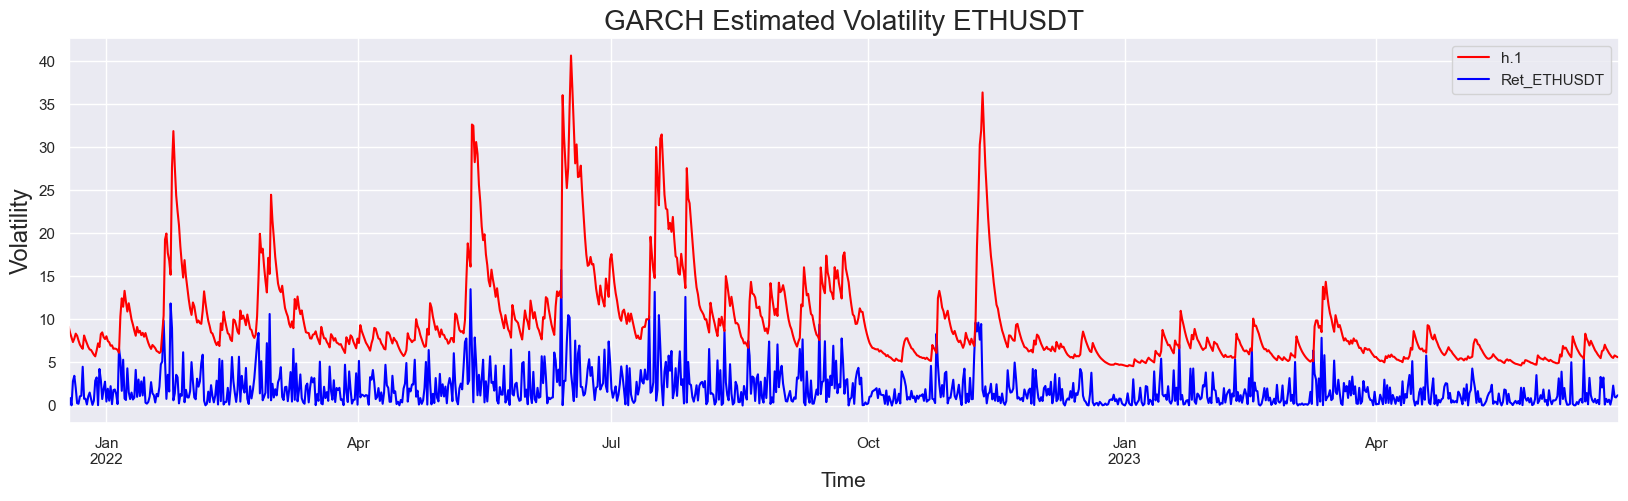

In [44]:
garch_volatility('ETHUSDT')

Iteration:     10,   Func. Count:     66,   Neg. LLF: 6042.567397166942
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6042.567397166942
            Iterations: 11
            Function evaluations: 70
            Gradient evaluations: 11


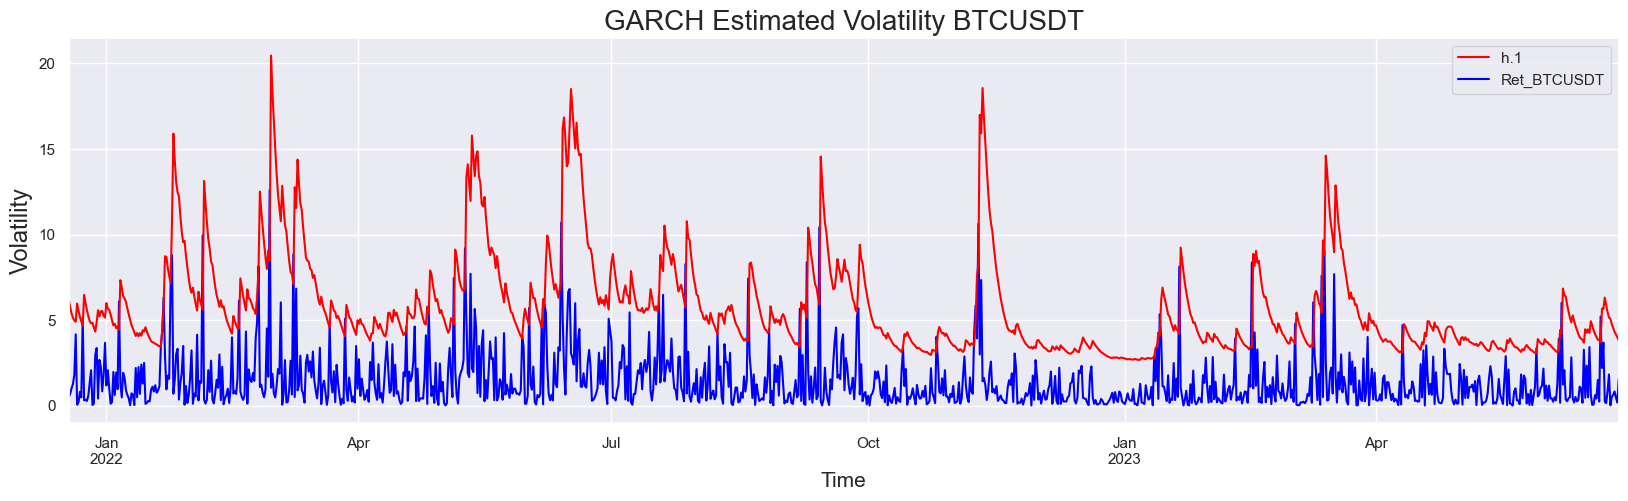

In [45]:
 garch_volatility('BTCUSDT')